In [1]:
import sys
import pandas as pd
from pathlib import Path
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import contextily as cx

import textwrap

# Add project root to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import src.config as config

plt.ioff()

In [2]:
from src.loadProcessed import load_selected_count, load_processed_locations

counts = load_selected_count()
locations = load_processed_locations()

location_specific_stats = pd.read_parquet(config.PROCESSED_DATA_DIR / 'location_specific_stats.parquet')

loc_stats_wlocinfo = location_specific_stats.merge(
    locations[['sensor_id', 'sensor_description', 'latitude', 'longitude']],
    left_index=True,
    right_on='sensor_id',
    how='left'
)

population_stats = pd.read_parquet(config.PROCESSED_DATA_DIR / 'population_stats.parquet')

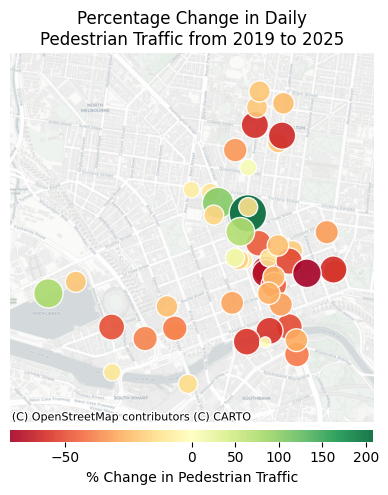

In [3]:

from pyproj import Transformer
from matplotlib.colors import TwoSlopeNorm, Normalize

plot_data = loc_stats_wlocinfo.copy()
plot_data['magnitude'] = plot_data['percent_year_change'].abs()

# Convert lat/lon to Web Mercator (meters) for Contextily
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
plot_data['x'], plot_data['y'] = transformer.transform(plot_data['longitude'].values, plot_data['latitude'].values)

fig, ax = plt.subplots(figsize=(4, 8))

# Create Colormap with Two-Slope Normalization
cmap = mpl.colormaps['RdYlGn']

# Two-slope norm centers at 0
traffic_change_norm = TwoSlopeNorm(
    vmin=plot_data['percent_year_change'].min(),
    vcenter=0,
    vmax=plot_data['percent_year_change'].max()
)

# Scatter points
sc = ax.scatter(
    plot_data['x'], plot_data['y'],
    cmap=cmap, 
    c=plot_data['percent_year_change'],
    norm=traffic_change_norm,
    edgecolors='white',
    s= 50 * np.sqrt(plot_data['magnitude']),
    alpha=.9,
    zorder=2
)

# Add colourbar
cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', 
                    fraction=0.03, pad=0.01, aspect=30)
cbar.set_label('% Change in Pedestrian Traffic', fontsize=10)
cbar.outline.set_visible(False)

# Set limits with a small buffer
buffer = 500
ax.set_xlim(plot_data['x'].min() - buffer, plot_data['x'].max() + buffer)
ax.set_ylim(plot_data['y'].min() - buffer, plot_data['y'].max() + buffer)

ax.set_title('Percentage Change in Daily\nPedestrian Traffic from 2019 to 2025')

# Stops map from being stretched
ax.set_aspect('equal')

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

plt.tight_layout()
plt.show()

# fig.savefig(config.WEBAPP_RESOURCES_DIR / "percent_change_plot.svg", transparent=True, bbox_inches='tight')

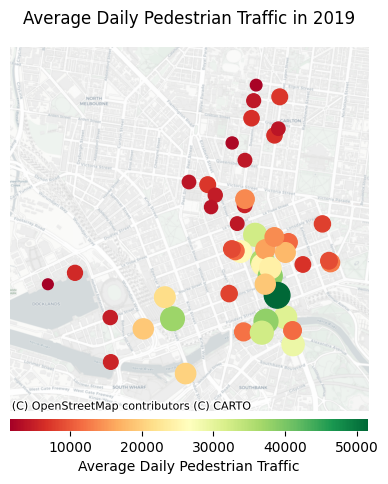

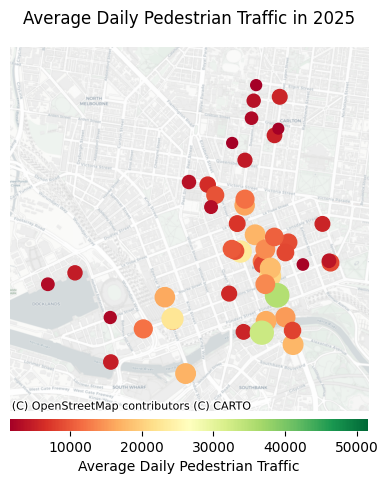

In [4]:
total_change_norm = Normalize(
    vmin=pd.concat([plot_data['count_2019_estimate'], plot_data['count_2025_estimate']]).min(),
    vmax=pd.concat([plot_data['count_2019_estimate'], plot_data['count_2025_estimate']]).max()
)

for year in ['2019', '2025']:
    fig, ax = plt.subplots(figsize=(4, 8))

    # Scatter points
    sc = ax.scatter(
        plot_data['x'], plot_data['y'],
        cmap=cmap, 
        c=plot_data[f'count_{year}_estimate'],
        norm=total_change_norm,
        s=1.5 * np.sqrt(plot_data[f'count_{year}_estimate']),
        # alpha=.7,
        zorder=2
    )

    # Add colourbar
    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', 
                        fraction=0.03, pad=0.01, aspect=30)
    cbar.set_label('Average Daily Pedestrian Traffic', fontsize=10)
    cbar.outline.set_visible(False)

    # Set limits with a small buffer
    buffer = 500
    ax.set_xlim(plot_data['x'].min() - buffer, plot_data['x'].max() + buffer)
    ax.set_ylim(plot_data['y'].min() - buffer, plot_data['y'].max() + buffer)

    ax.set_aspect('equal')

    ax.set_title(f'Average Daily Pedestrian Traffic in {year}')

    # Add basemap
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    ax.set_axis_off()

    plt.tight_layout()
    plt.show()

    # fig.savefig(config.WEBAPP_RESOURCES_DIR / f"counts_map_plot_{year}.svg", transparent=True, bbox_inches='tight')

In [5]:
# Get RGB values at intermediate positions on the colormap [0, 1]
for pos in range(0, 10, 1):
    rgba = cmap(pos/10)
    rgb = [int(255*rgba[0]), int(255*rgba[1]), int(255*rgba[2])]
    print(f"Position {pos/10}: RGB={rgb}")

Position 0.0: RGB=[165, 0, 38]
Position 0.1: RGB=[214, 47, 38]
Position 0.2: RGB=[244, 109, 67]
Position 0.3: RGB=[252, 172, 96]
Position 0.4: RGB=[254, 224, 139]
Position 0.5: RGB=[254, 254, 189]
Position 0.6: RGB=[217, 239, 139]
Position 0.7: RGB=[164, 216, 105]
Position 0.8: RGB=[102, 189, 99]
Position 0.9: RGB=[25, 151, 79]


## Adding Colour

In [6]:
pydeck_data = loc_stats_wlocinfo.copy()
pydeck_data['count_difference_2025_2019'] = pydeck_data['count_2025_estimate'] - pydeck_data['count_2019_estimate']
pydeck_data['absolute_change'] = abs(pydeck_data['count_difference_2025_2019'])

In [7]:
# import cmasher as cmr
# import matplotlib.colors as mplcolors

# # Apply colourmap to data

# cmap = cmr.get_sub_cmap("cmr.prinsenvlag", 0.0, 1.0)
# # cmap = cmap.reversed()

# normalised_colour_map = mplcolors.Normalize(
#     vmin=pydeck_data['percent_year_change'].min(),
#     vcenter=0,
#     vmax=pydeck_data['percent_year_change'].max()
# )

# def cmr_to_rgb(value):
#     r, g, b, _ = cmap(normalised_colour_map(value))
#     return [int(255*r), int(255*g), int(255*b)]

# pydeck_data['colour'] = pydeck_data['percent_year_change'].apply(cmr_to_rgb)

In [8]:
def two_colour_map(pchange):
    if pchange > 0:
        return  [132, 202, 102]
    else:
        return [244, 109, 67]

pydeck_data['colour'] = pydeck_data['count_difference_2025_2019'].apply(
    two_colour_map
)

In [9]:
export_cols = [
    "longitude",
    "latitude",
    "count_difference_2025_2019",
    "absolute_change",
    "sensor_description",
    "colour",
    "sensor_id"
]

pydeck_data[export_cols].to_json(
    config.WEBAPP_RESOURCES_DIR / "pedestrian_data.json",
    orient="records"
)

## Graphing Sensor Plots

In [10]:
sensors = counts['sensor_id'].unique()

rgb_grn_frac = tuple(np.divide([132, 202, 102], 256))
rgb_blu_frac = tuple(np.divide([13, 110, 253], 256))
rgb_red_frac = tuple(np.divide([244, 109, 67], 256))

bootstrap_secondary = tuple(np.divide([33, 37, 41], 256))

days = np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
weekend = np.array(['Saturday', 'Sunday'])
weekdays = np.setdiff1d(days, weekend)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

for s_id in sensors:
    
    sensor_location = locations[locations['sensor_id'] == s_id].squeeze()
    sensor_counts = counts[counts['sensor_id'] == s_id]

    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.set_title(f'Pedestrian Traffic at {sensor_location['sensor_description']}', fontsize=16, pad=20)

    sensor_counts_2019 = sensor_counts[sensor_counts['sensing_date'].dt.year == 2019]
    sensor_counts_2025 = sensor_counts[sensor_counts['sensing_date'].dt.year == 2025]

    ax.plot(
        sensor_counts_2019['sensing_date'].dt.day_of_year,
        sensor_counts_2019['daily_count'],
        color=rgb_blu_frac,
        alpha=0.8,
        linewidth=2.5,
        label='2019'
    )
    ax.plot(
        sensor_counts_2025['sensing_date'].dt.day_of_year,
        sensor_counts_2025['daily_count'],
        color=rgb_grn_frac,
        alpha=0.8,
        linewidth=2.5,
        label='2025'
    )
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_xlim(0, 370)
    ax.set_ylim(0)
    ax.set_xlabel('Day of the year', fontsize=12)
    ax.set_ylabel('Daily pedestrian count', fontsize=12)

    ax.legend(fontsize=11, loc='upper left', framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    # fig.savefig(config.WEBAPP_RESOURCES_DIR / 'sensorplots' / f"{s_id}_sensor_plot.svg", transparent=True, bbox_inches='tight')

    plt.close()

## Plotting the effects as overlay on counts

In [12]:
for s_id in sensors:
    
    sensor_stats = loc_stats_wlocinfo[loc_stats_wlocinfo['sensor_id'] == s_id].squeeze()
    sensor_counts = counts[counts['sensor_id'] == s_id]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    
    # 2019 Plot
    sensor_counts_2019 = sensor_counts[sensor_counts['sensing_date'].dt.year == 2019]
    weekend_counts_2019 = sensor_counts_2019[sensor_counts_2019['day'].isin(weekend)]
    weekday_counts_2019 = sensor_counts_2019[sensor_counts_2019['day'].isin(weekdays)]

    weekday_rolling_2019 = weekday_counts_2019[['daily_count', 'sensing_date']].rolling(window='14D', on='sensing_date').mean()
    weekend_rolling_2019 = weekend_counts_2019[['daily_count', 'sensing_date']].rolling(window='14D', on='sensing_date').mean()

    ax1.plot(weekday_rolling_2019['sensing_date'].dt.day_of_year, weekday_rolling_2019['daily_count'],
         color=rgb_red_frac, alpha=0.5, label='Weekday')
    ax1.plot(weekend_rolling_2019['sensing_date'].dt.day_of_year, weekend_rolling_2019['daily_count'],
        color=rgb_grn_frac, alpha=0.5, label='Weekend')
    
    ax1.axhline(y=sensor_stats['wkdy_count_2019_estimate'], color=rgb_red_frac, linewidth=2, label='Weekday Fit', linestyle='--')
    ax1.axhline(y=sensor_stats['wknd_count_2019_estimate'], color=rgb_grn_frac, linewidth=2, label='Weekend Fit', linestyle='--')
    
    ax1.set_title('2019', fontsize=14)
    ax1.set_ylabel('Daily pedestrian count', fontsize=11)
    ax1.set_xlim(0, 365)
   
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator())

    ax1.grid(True, alpha=0.3, linestyle='--', axis='y')

    ax1.legend(fontsize=9, frameon=False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # 2025 Plot
    sensor_counts_2025 = sensor_counts[sensor_counts['sensing_date'].dt.year == 2025]
    weekend_counts_2025 = sensor_counts_2025[sensor_counts_2025['day'].isin(weekend)]
    weekday_counts_2025 = sensor_counts_2025[sensor_counts_2025['day'].isin(weekdays)]

    weekday_rolling_2025 = weekday_counts_2025[['daily_count', 'sensing_date']].rolling(window="14D", on='sensing_date').mean()
    weekend_rolling_2025 = weekend_counts_2025[['daily_count', 'sensing_date']].rolling(window="14D", on='sensing_date').mean()

    ax2.plot(weekday_rolling_2025['sensing_date'].dt.day_of_year, weekday_rolling_2025['daily_count'],
            color=rgb_red_frac, alpha=0.5, label='Weekday')
    ax2.plot(weekend_rolling_2025['sensing_date'].dt.day_of_year, weekend_rolling_2025['daily_count'],
            color=rgb_grn_frac, alpha=0.5, label='Weekend')
    
    ax2.axhline(y=sensor_stats['wkdy_count_2025_estimate'], color=rgb_red_frac, linewidth=2, label='Weekday Fit', linestyle='--')
    ax2.axhline(y=sensor_stats['wknd_count_2025_estimate'], color=rgb_grn_frac, linewidth=2, label='Weekend Fit', linestyle='--')
    
    ax2.set_title('2025', fontsize=14)
    ax2.set_xlim(0, 365)

    ax2.grid(True, alpha=0.3, linestyle='--', axis='y')


    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator())

    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    fig.suptitle(f'Comparing Observed and Fitted Pedestrian Counts at {sensor_stats["sensor_description"]}', fontsize=16)
    plt.tight_layout()
    # plt.show()
    
    # fig.savefig(config.WEBAPP_RESOURCES_DIR / 'sensorfits' / f"{s_id}_sensor_fit.svg", transparent=True, bbox_inches='tight')

    plt.close()

## Plotting Sensor Specific Day Responses

In [13]:
for s_id in sensors:
    sensor_stats = loc_stats_wlocinfo[loc_stats_wlocinfo['sensor_id'] == s_id].squeeze()
    
    plot_data = sensor_stats[['wkdy_percent_year_change', 'wknd_percent_year_change', 'percent_year_change']]

    fig, ax = plt.subplots(figsize=(4, 5))

    bars = ax.bar(
        ['Weekday', 'Weekend', 'Average'], plot_data, 
        color=plot_data.apply(lambda val: rgb_grn_frac if val > 0 else rgb_red_frac),
        alpha=0.8, edgecolor='white', linewidth=1.5
    )

    ax.set_title(
        textwrap.fill(
            f'Percentage Change in Pedestrian Traffic in {sensor_stats["sensor_description"]}',
            width=36  # Adjust this to control where it wraps
        ), 
        fontsize=16, pad=20
    )
    ax.set_ylabel('Percentage Change (%)', fontsize=12)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    padding = 10
    scale = np.max([np.abs(plot_data).max(), 100 - padding])
    ax.set_ylim(
        -(scale + padding), scale + padding
    )

    plt.tight_layout()
    # plt.show()
    plt.close()

    # fig.savefig(config.WEBAPP_RESOURCES_DIR / 'sensordays' / f"{s_id}_sensordays.svg", transparent=True, bbox_inches='tight')

        

## Plotting Day Effects

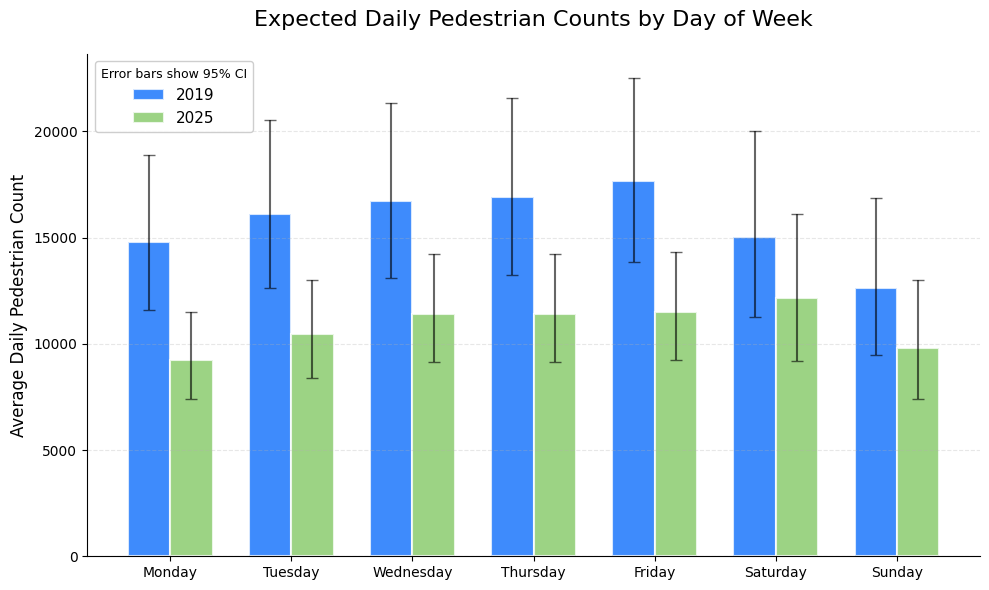

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))


# Use your existing color scheme
rgb_grn_frac = tuple(np.divide([132, 202, 102], 256))
rgb_blu_frac = tuple(np.divide([13, 110, 253], 256))

# Extract data for both years
est_2019 = [population_stats.loc['estimate', f'{day}_expected_2019'] for day in days]
est_2025 = [population_stats.loc['estimate', f'{day}_expected_2025'] for day in days]

lower_2019 = [population_stats.loc['lower', f'{day}_expected_2019'] for day in days]
upper_2019 = [population_stats.loc['upper', f'{day}_expected_2019'] for day in days]

lower_2025 = [population_stats.loc['lower', f'{day}_expected_2025'] for day in days]
upper_2025 = [population_stats.loc['upper', f'{day}_expected_2025'] for day in days]

# Calculate error bar sizes (distance from estimate to CI bounds)
err_2019 = [np.array(est_2019) - np.array(lower_2019), np.array(upper_2019) - np.array(est_2019)]
err_2025 = [np.array(est_2025) - np.array(lower_2025), np.array(upper_2025) - np.array(est_2025)]

# Set up bar positions
x = np.arange(len(days))
width = 0.35

# Create bars with error bars
bars1 = ax.bar(x - width/2, est_2019, width, label='2019', 
               color=rgb_blu_frac, alpha=0.8, edgecolor='white', linewidth=1.5,
               yerr=err_2019, capsize=4, error_kw={'alpha': 0.6})

bars2 = ax.bar(x + width/2, est_2025, width, label='2025', 
               color=rgb_grn_frac, alpha=0.8, edgecolor='white', linewidth=1.5,
               yerr=err_2025, capsize=4, error_kw={'alpha': 0.6})

ax.set_title('Expected Daily Pedestrian Counts by Day of Week', fontsize=16, pad=20)
ax.set_ylabel('Average Daily Pedestrian Count', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(days)
ax.set_ylim(0, max(upper_2019)* 1.05)

ax.legend(fontsize=11, loc='upper left', framealpha=0.95, title='Error bars show 95% CI', title_fontsize=9)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

# fig.savefig(config.WEBAPP_RESOURCES_DIR / "day_effects.svg", transparent=True, bbox_inches='tight')

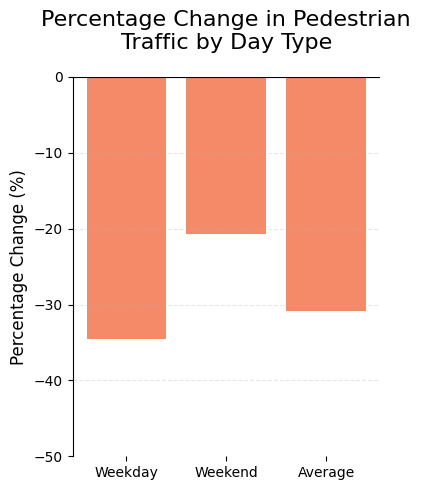

In [15]:


frac_change_weekend = (
    np.mean([population_stats[f'{d}_expected_2025'] for d in weekend]) 
    / np.mean([population_stats[f'{d}_expected_2019'] for d in weekend])
    - 1
) * 100
frac_change_weekday = (
    np.mean([population_stats[f'{d}_expected_2025'] for d in np.setdiff1d(days, weekend)]) 
    / np.mean([population_stats[f'{d}_expected_2019'] for d in np.setdiff1d(days, weekend)])
    - 1
) * 100
frac_change_average = (population_stats['mean_expected_2025']['estimate'] / population_stats['mean_expected_2019']['estimate'] - 1) * 100

plot_data = pd.DataFrame({
    'Category': ['Weekday', 'Weekend', 'Average'],
    'Percentage Change': [frac_change_weekday, frac_change_weekend, frac_change_average]
})

fig, ax = plt.subplots(figsize=(4, 5))

bars = ax.bar(plot_data['Category'], plot_data['Percentage Change'], 
               color=rgb_red_frac, alpha=0.8, linewidth=1.5)

ax.set_title('Percentage Change in Pedestrian\nTraffic by Day Type', 
             fontsize=16, pad=20)
ax.set_ylabel('Percentage Change (%)', fontsize=12)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_ylim(-50, 0)

plt.tight_layout()
# plt.show()
# fig.savefig(config.WEBAPP_RESOURCES_DIR / "change_by_day_type.svg", transparent=True, bbox_inches='tight')

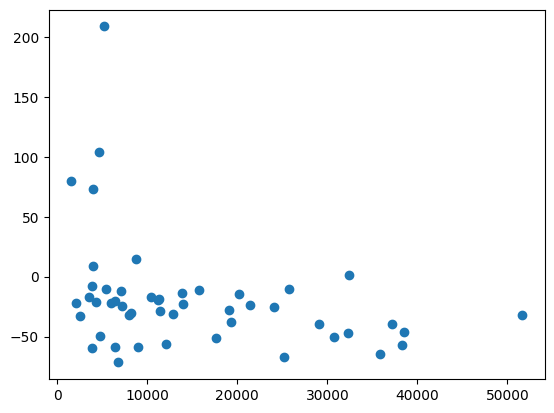

In [16]:
fig, ax = plt.subplots()

ax.scatter(location_specific_stats['count_2019_estimate'], location_specific_stats['percent_year_change'])

plt.show()